<h1 style="text-align:center; font-size: 60px; font-weight: 200">digest2 Score Analysis</h1>

In [4]:
import pandas as pd

import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

from datetime import date

import numpy as np
from os import listdir

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import lsst_neocp
import helpers

import difi

In [5]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [4]:
from importlib import reload

# Set up S3M ID conversion

In [5]:
s3m = pd.read_hdf("../catalogues/s3m_initial.h5")
hex_ids = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m.index.values))])
s3m_to_hex7 = dict(zip(s3m.index.values, hex_ids))

# Get NEO scores

### Attach extra info to files

In [6]:
def attach_nobs_scores_to_files(file_ids=range(24), path="mba/"):
    # go through each visit file
    for file in file_ids:
        print(f"Starting file {file}")
        # read in the file and set hex_id as the index
        visit_file = pd.read_hdf(path + f"filtered_visit_{file:03d}.h5")
        visit_file.set_index("hex_id", inplace=True)

        # get a list of nights in the file
        nights = np.sort(visit_file["night"].unique())
        nightly_visits = [None for _ in range(len(nights))]

        # loop over the nights
        for i, night in enumerate(nights):
            # get the specific rows for this night
            nightly_visit_file = visit_file[visit_file["night"] == night]

            # calculate n_obs for each row and save as a new column
            n_obs = nightly_visit_file.groupby("ObjID").size().to_frame("n_obs")
            nightly_visit_file = nightly_visit_file.join(n_obs, on="ObjID")

            # read in the scores, remove duplicates
            scores, hex_ids = helpers.get_neo_scores(path, night=night)
            uni, inds = np.unique(hex_ids, return_index=True)

            # add scores as a new column
            scores_df = pd.DataFrame(dict(scores=scores[inds], hex_id=hex_ids[inds])).set_index("hex_id")
            nightly_visits[i] = nightly_visit_file.join(scores_df, on="hex_id")

            print(f"  Done with night {night}")

        # recombine the dataframes and save as a new file
        visit_file = pd.concat(nightly_visits)
        visit_file.to_hdf(path + f"filtered_visit_scores_{file:03d}.h5", key="df")

        print(f"  Done saving")

In [ ]:
attach_nobs_scores_to_files(path="neo/")

In [ ]:
attach_nobs_scores_to_files(path="mba/")

### get scores for different n_obs

In [7]:
def get_counts(path="neo/", n_obs_list=[2, 3, 4, 5, 6], last_night=377):
    counts = np.zeros((last_night, len(n_obs_list))).astype(int)

    for file in range(24):
        print(f"file {file}")
        visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")
        nights = visit_file["night"].unique()
        for night in nights:
            if night >= last_night:
                break
            nightly_visit = visit_file[visit_file["night"] == night]
            grouped = nightly_visit.groupby("hex_id").first()

            for i, n_obs in enumerate(n_obs_list):
                counts[night, i] += len(grouped[np.logical_and(grouped["n_obs"] >= n_obs,
                                                               grouped["scores"] >= 65)])
    return counts

In [8]:
neo_counts = get_counts()

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
file 22
file 23


In [9]:
%%time
mba_counts = get_counts(path="mba/")

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
file 22
file 23


## NEOCP Traffic and Purity

In [10]:
nights = np.arange(377)
n_obs_list = [2, 3, 4, 5, 6]

In [11]:
total_traffic = neo_counts + mba_counts

In [12]:
bad_weather = nights[total_traffic[:, 0] == 0]

In [13]:
bad_weather

array([  2,   3,   4,   5,   6,   7,   8,  32,  33,  34,  38,  48,  51,
        55,  80,  81,  84,  92,  96,  97,  99, 100, 101, 102, 103, 104,
       105, 106, 116, 117, 120, 123, 125, 126, 127, 153, 155, 156, 158,
       164, 176, 177, 189, 190, 194, 195, 206, 207, 208, 209, 210, 211,
       212, 213, 233, 241, 248, 249, 250, 251, 252, 253, 254, 300, 301,
       302, 357, 360])

In [14]:
purity = neo_counts / total_traffic

/tmp/ipykernel_3592/4177174142.py:1: RuntimeWarning: invalid value encountered in true_divide
  purity = neo_counts / total_traffic


In [15]:
def weekly_mean(x, bad_weather):
    y = np.repeat(np.nan, len(x))
    for i in range(len(x)):
        if i not in bad_weather:
            inds = np.arange(max(0, i - 3), min(i + 3 + 1, len(x)))
            inds = inds[~np.isin(inds, bad_weather)]
            y[i] = np.mean(x[inds])
    return y

In [16]:
def running_mean(x, window=5):
    y = np.zeros(len(x))
    for i in range(len(y) - window):
        x_wind = x[i:i+window]
        if x[i] == 0 or np.isnan(x[i]):
            y[i] = np.nan
        else:
            assert np.any(x_wind > 0), x_wind
            y[i] = np.mean(x_wind[x_wind > 0])
    return y

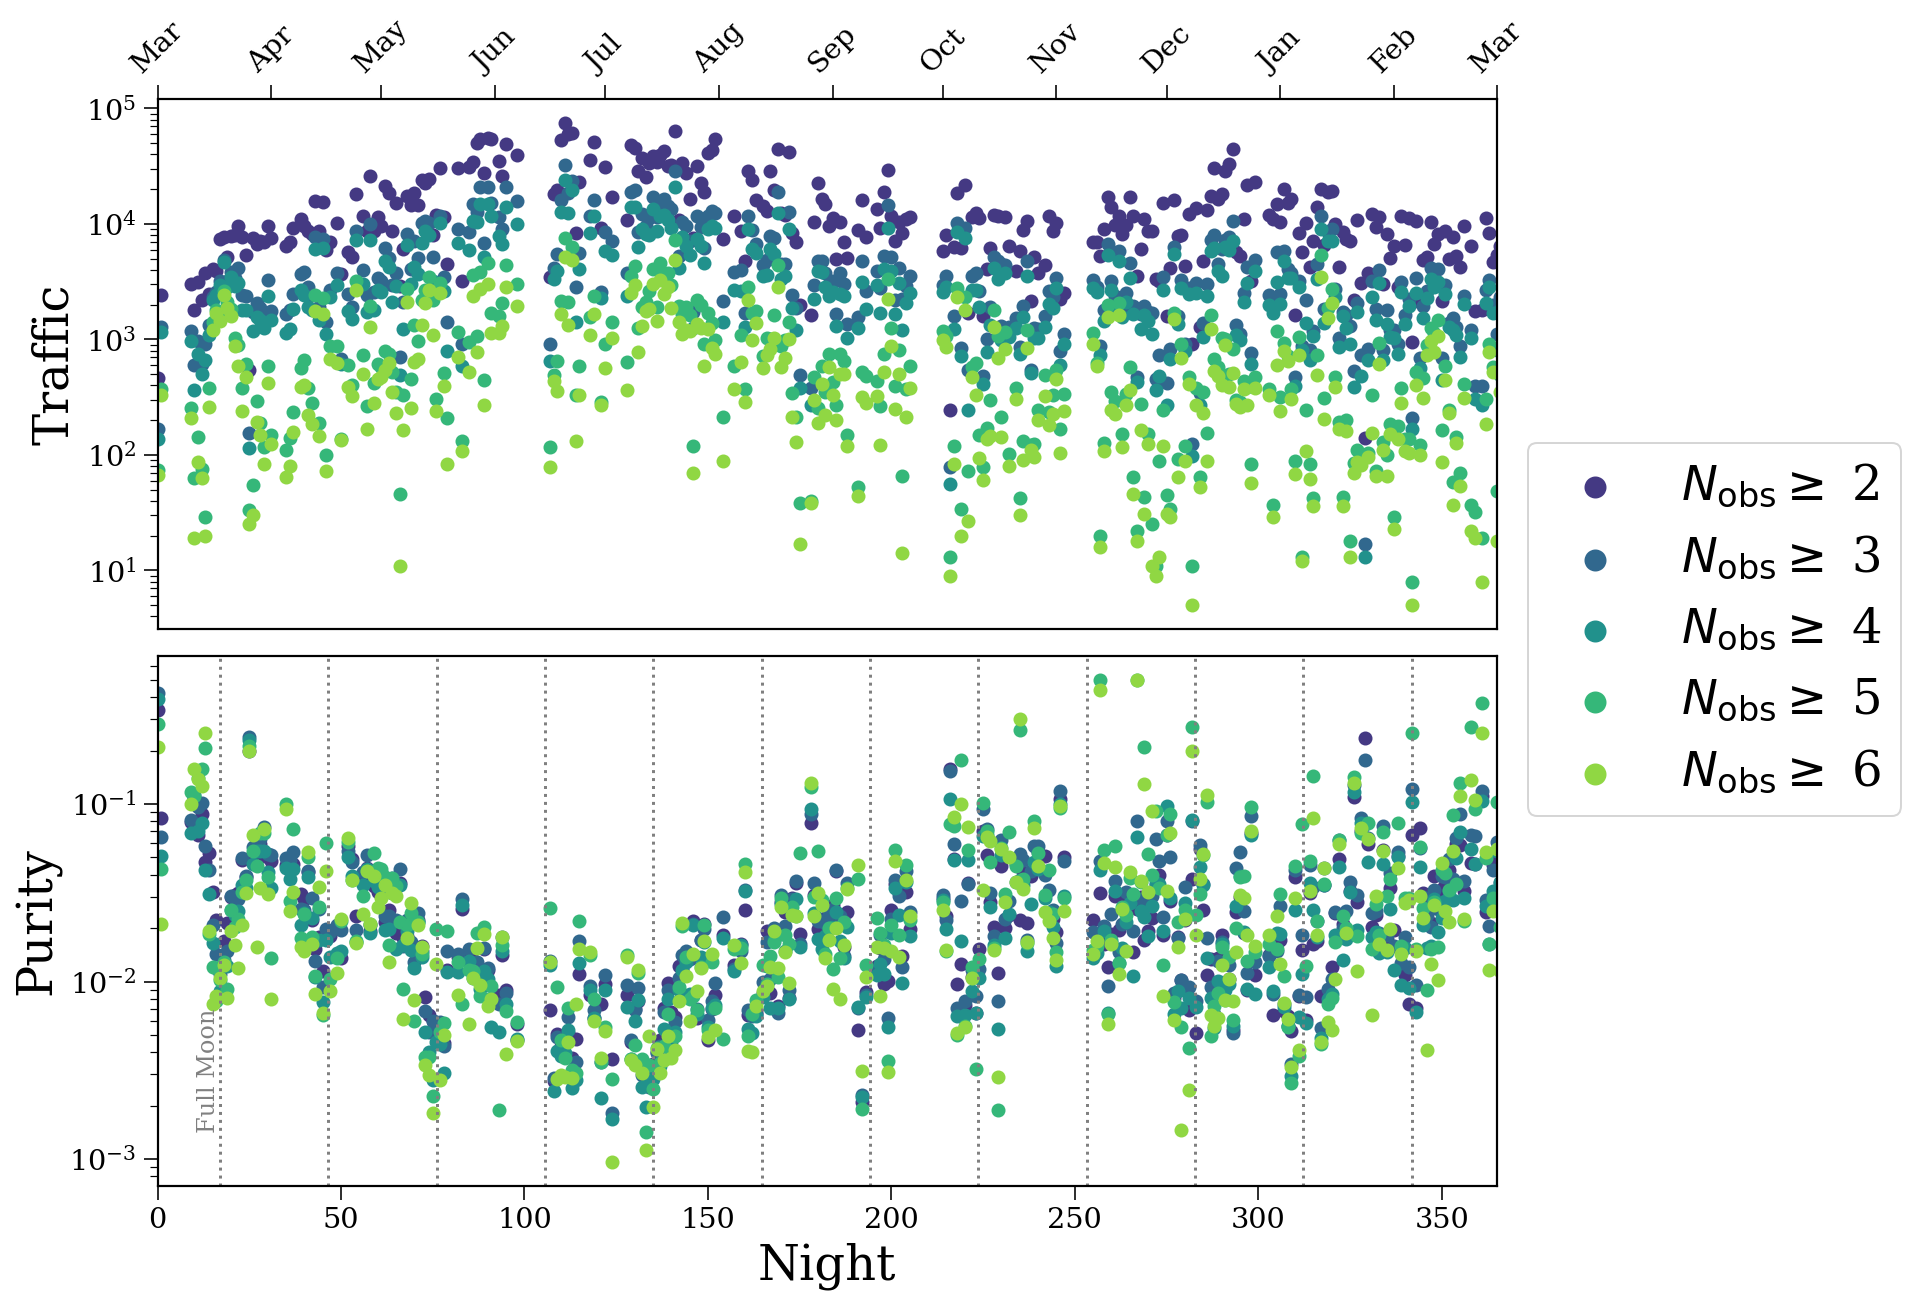

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", 7)(i + 1) for i in range(len(n_obs_list))]

for i in range(len(n_obs_list)):
    nonzero = total_traffic.T[i] > 0
    axes[0].scatter(nights[nonzero], total_traffic.T[i][nonzero],
                    label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}", color=colours[i])
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

for i in range(len(n_obs_list)):
    nonzero = total_traffic.T[i] > 0
    axes[1].scatter(nights[nonzero], purity.T[i][nonzero], color=colours[i])
axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")

# moon lines
for i in range(13):
    axes[1].axvline(17 + 29.53 * i, color="grey", linestyle="dotted")
axes[1].annotate("Full Moon", xy=(17, 0.0015), rotation=90, color="grey", ha="right", fontsize=0.5*fs)

labels = ["March", "April", "May", "June", "July", "August", "September",
          "October", "November", "December", "January", "February", "March"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)

leg = axes[0].legend(loc="center right", bbox_to_anchor=(1.32, 0))
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

plt.show()

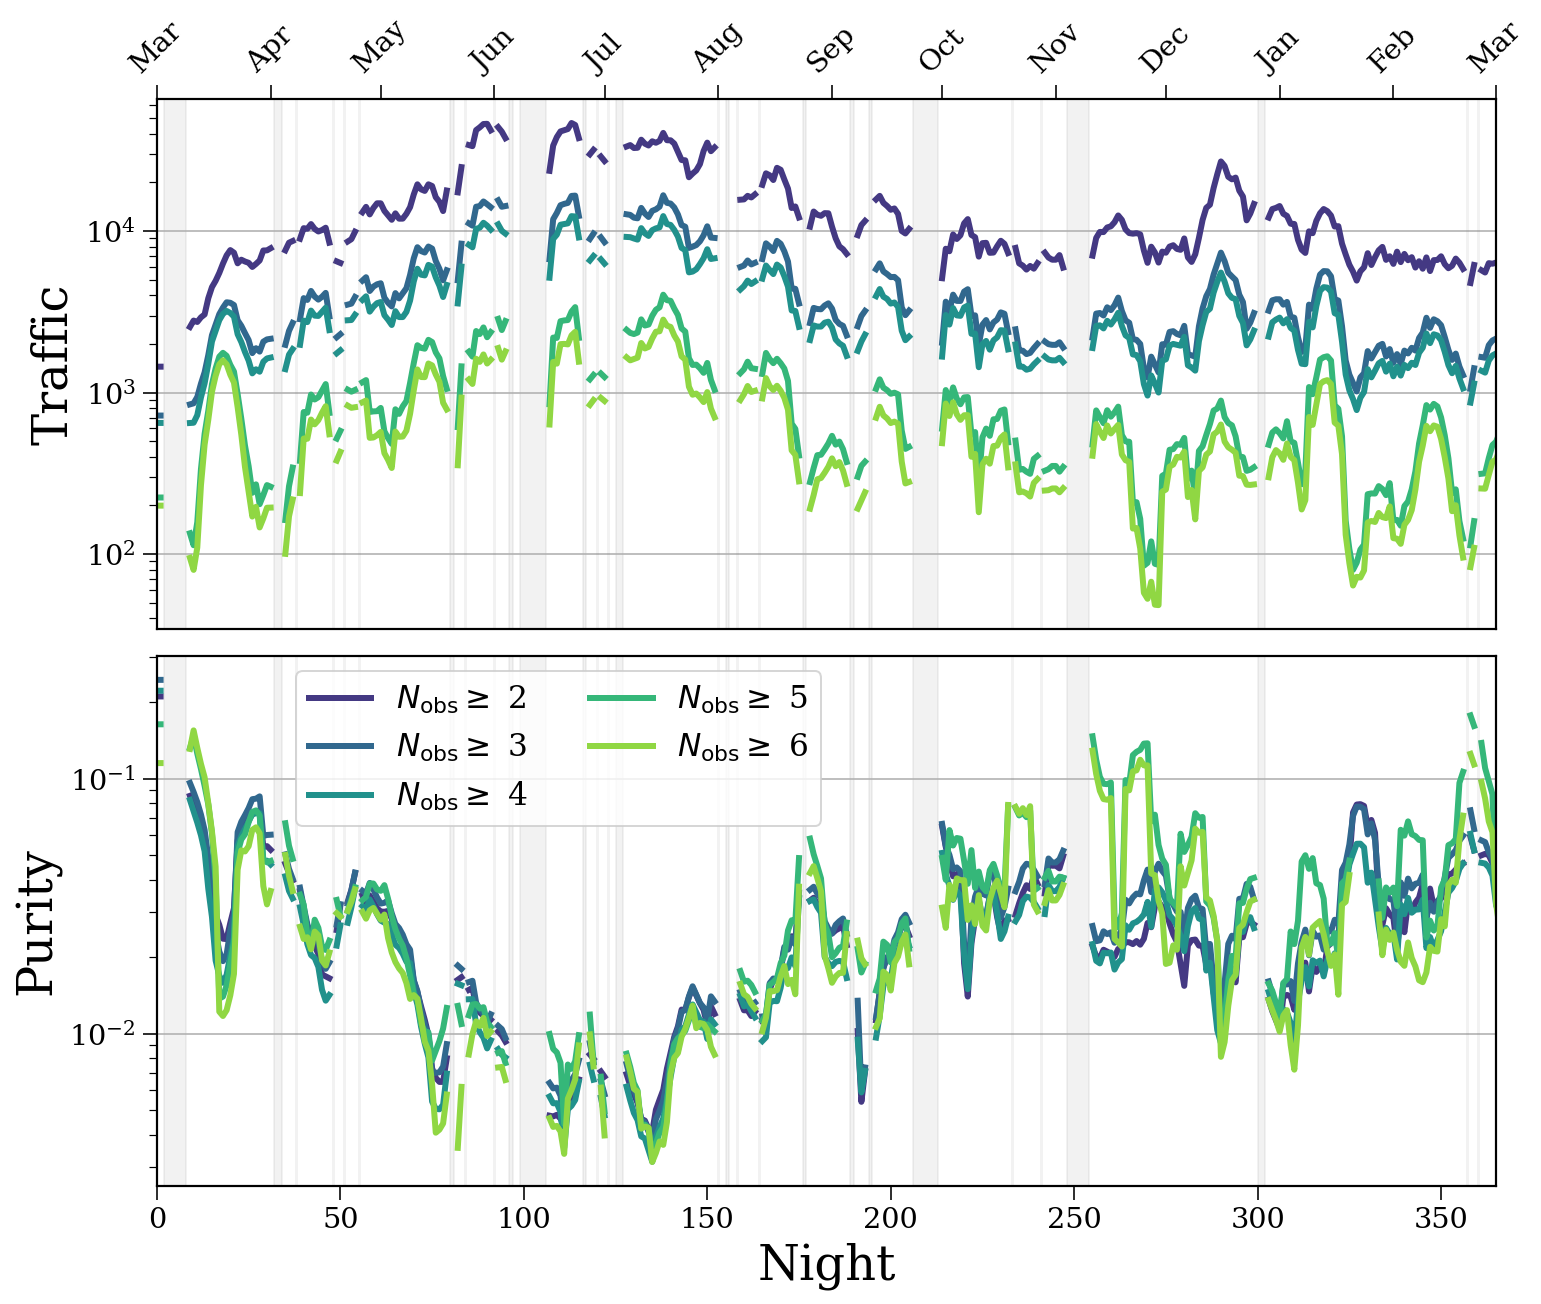

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

for i in range(len(n_obs_list)):
    axes[0].plot(nights, weekly_mean(total_traffic.T[i], bad_weather),
                 color=colours[i], lw=3)
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

for i in range(len(n_obs_list)):
    axes[1].plot(nights, weekly_mean(purity.T[i], bad_weather),
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    
axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")
    
leg = axes[1].legend(loc="upper center", ncol=2, fontsize=0.65*fs, bbox_to_anchor=(0.3, 1))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["March", "April", "May", "June", "July", "August", "September",
          "October", "November", "December", "January", "February", "March"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    i = 0
    while i < len(bad_weather):
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather):
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1

plt.show()

# DIFI things

In [19]:
f2n = [[0, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       [31, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46],
       [46, 47, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61],
       [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72],
       [72, 73, 74, 75, 76, 77, 78, 79, 82, 83, 85, 86, 87, 88, 89],
       [89, 90, 91, 93, 94, 95, 98, 107, 108, 109, 110, 111, 112],
       [112, 113, 114, 115, 118, 119, 121, 122, 124, 128, 129, 130, 131, 132],
       [132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
       [144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 157, 159],
       [159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171],
       [171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185],
       [185, 186, 187, 188, 191, 192, 193, 196, 197, 198, 199, 200, 201, 202],
       [202, 203, 204, 205, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224],
       [224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 238, 239],
       [239, 240, 242, 243, 244, 245, 246, 247, 255, 256, 257, 258, 259, 260],
       [260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275],
       [275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289],
       [289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 303, 304, 305, 306, 307, 308],
       [308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322],
       [322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337],
       [337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350],
       [350, 351, 352, 353, 354, 355, 356, 358, 359, 361, 362, 363, 364, 365],
       [365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377]]

In [2]:
def get_findable_hex_ids(path="neo/", file_ids=range(24)):
                         
    obs_dfs = [pd.read_hdf(path + f"filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")[["FieldMJD", "night"]]
               for i in file_ids]
    all_obs = pd.concat(obs_dfs)
    all_obs["obs_id"] = np.arange(len(all_obs))
    all_obs.reset_index(inplace=True)
    
    print("Obs file done")

    findable_hex_ids = None

    all_truths, findable_obs, summary = difi.analyzeObservations(
        observations=all_obs,
        classes=None,
        metric="nightly_linkages",
        column_mapping={"obs_id": "obs_id", "truth": "hex_id", "night": "night", "time": "FieldMJD"}
    )

    findable_hex_ids = all_truths[all_truths["findable"] == 1]["hex_id"].values

    return findable_hex_ids

In [41]:
path="neo/"

all_obs = pd.read_hdf(path + f"filtered_visit_scores_{0:03d}.h5").sort_values("FieldMJD")
# all_obs = all_obs[all_obs["night"] <= 15]

all_obs["obs_id"] = np.arange(len(all_obs))
all_obs.reset_index(inplace=True)

print("Obs file done")

findable_hex_ids = None

all_truths, findable_obs, summary = difi.analyzeObservations(
    observations=all_obs[["FieldMJD", "night"]],
    classes=None,
    metric="nightly_linkages",
    column_mapping={"obs_id": "obs_id", "truth": "hex_id", "night": "night", "time": "FieldMJD"}
)

findable_hex_ids = all_truths[all_truths["findable"] == 1]["hex_id"].values

Obs file done


KeyError: 'hex_id'

In [37]:
findable_obs[findable_obs["hex_id"] == "0000AE9"]

,hex_id,obs_ids


In [43]:
all_obs[all_obs["hex_id"] == "0000AE9"]

,hex_id,ObjID,night,FieldMJD,AstRA(deg),AstDec(deg),filter,MaginFilter,AstrometricSigma(mas),PhotometricSigma(mag),n_obs,scores,obs_id
350,0000AE9,S00000Kea,0,59639.159318,120.636966,-33.537319,i,18.059454,10.028934,0.002297,2,100,350
398,0000AE9,S00000Kea,0,59639.183344,120.628100,-33.488371,r,18.255159,10.026386,0.002076,2,100,398
1505,0000AE9,S00000Kea,9,59648.043450,118.107495,-5.524050,r,17.333819,10.008204,0.001367,3,100,1505
1609,0000AE9,S00000Kea,9,59648.069169,118.099221,-5.408996,i,17.131157,10.019554,0.001675,3,100,1609
1685,0000AE9,S00000Kea,9,59648.093098,118.091548,-5.301745,z,17.182566,10.023423,0.002109,3,100,1685


In [40]:
all_truths[all_truths["hex_id"] == "000FFEA"]

,hex_id,num_obs,findable
688,000FFEA,4,0


In [22]:
np.sort(findable_hex_ids)

array(['0000095', '000009B', '00000A2', '00000D7', '00000EE', '0000140',
       '0000173', '0000188', '00001A3', '0000212', '0000240', '0000243',
       '0000315', '0000344', '0000364', '0000369', '00003EC', '00004CB',
       '00004D2', '00004FD', '00005C5', '0000603', '0000656', '0000682',
       '0000699', '00006A6', '00006AD', '00006D1', '0000706', '0000730',
       '000075D', '0000791', '000083F', '00008A3', '00008B4', '00008E8',
       '0000901', '0000928', '0000966', '00009C9', '00009E5', '0000A48',
       '0000ADB', '0000AE6', '0000AFE', '0000B28', '0000CE0', '0000D4B',
       '0000D51', '0000D91', '0000DBE', '0000E19', '0000E1F', '0000E4C',
       '0000EE7', '0000F47', '000100F', '0001037', '000106D', '0001113',
       '000121A', '00012DC', '0001395', '00013AB', '00013B3', '00013D5',
       '00014B6', '00014C3', '000156C', '00015C9', '0001611', '0001675',
       '00016C7', '00016DE', '0001841', '0001855', '0001A30', '0001A4B',
       '0001B09', '0001C31', '0001C39', '0001CC6', 

In [17]:
np.save("../lsst_detection_probability/neo_findable_first_15.npy", findable_hex_ids)

In [12]:
all_truths[all_truths["hex_id"] == "000095E"]

,hex_id,num_obs,findable
5916,000095E,13,1


In [6]:
%%time
findable_neo_hex_ids = get_findable_hex_ids()

Obs file done
CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 11.8 s


In [9]:
np.isin("000095E", findable_neo_hex_ids)

array(True)

In [6]:
%%time
findable_mba_hex_ids = get_findable_hex_ids(path="mba/")

Obs file done
CPU times: user 40min 59s, sys: 4min 15s, total: 45min 14s
Wall time: 44min 57s


In [7]:
unique_findable_neo_hex_ids = np.unique(findable_neo_hex_ids)
unique_findable_mba_hex_ids = np.unique(findable_mba_hex_ids)

In [8]:
np.save("unique_findable_neo_hex_ids_linked.npy", unique_findable_neo_hex_ids)
np.save("unique_findable_mba_hex_ids_linked.npy", unique_findable_mba_hex_ids)

In [22]:
unique_findable_neo_hex_ids = np.load("unique_findable_neo_hex_ids_linked.npy", allow_pickle=True)
unique_findable_mba_hex_ids = np.load("unique_findable_mba_hex_ids_linked.npy", allow_pickle=True)

In [23]:
def get_counts(path="neo/", n_obs_list=[2, 3, 4, 5, 6], last_night=377, findable_hex_ids=None):
    counts = np.zeros((last_night, len(n_obs_list))).astype(int)

    for file in range(24):
        print(f"file {file}")
        visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")
        nights = visit_file["night"].unique()
        for night in nights:
            if night >= last_night:
                break
            nightly_visit = visit_file[visit_file["night"] == night]
            grouped = nightly_visit.groupby("hex_id").first()

            if findable_hex_ids is not None:
                grouped = grouped[~grouped.index.isin(findable_hex_ids)]
            
            for i, n_obs in enumerate(n_obs_list):
                counts[night, i] += len(grouped[np.logical_and(grouped["n_obs"] >= n_obs,
                                                               grouped["scores"] >= 65)])
    return counts

In [24]:
neo_counts_unfindable = get_counts(findable_hex_ids=unique_findable_neo_hex_ids)

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
file 22
file 23


In [25]:
%%time
mba_counts_unfindable = get_counts(path="mba/", findable_hex_ids=unique_findable_mba_hex_ids)

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
file 22
file 23
CPU times: user 11min 27s, sys: 1min 20s, total: 12min 48s
Wall time: 12min 38s


In [26]:
total_traffic_unfindable = neo_counts_unfindable + mba_counts_unfindable

In [27]:
purity_unfindable = neo_counts_unfindable / total_traffic_unfindable

/tmp/ipykernel_3592/1320287732.py:1: RuntimeWarning: invalid value encountered in true_divide
  purity_unfindable = neo_counts_unfindable / total_traffic_unfindable


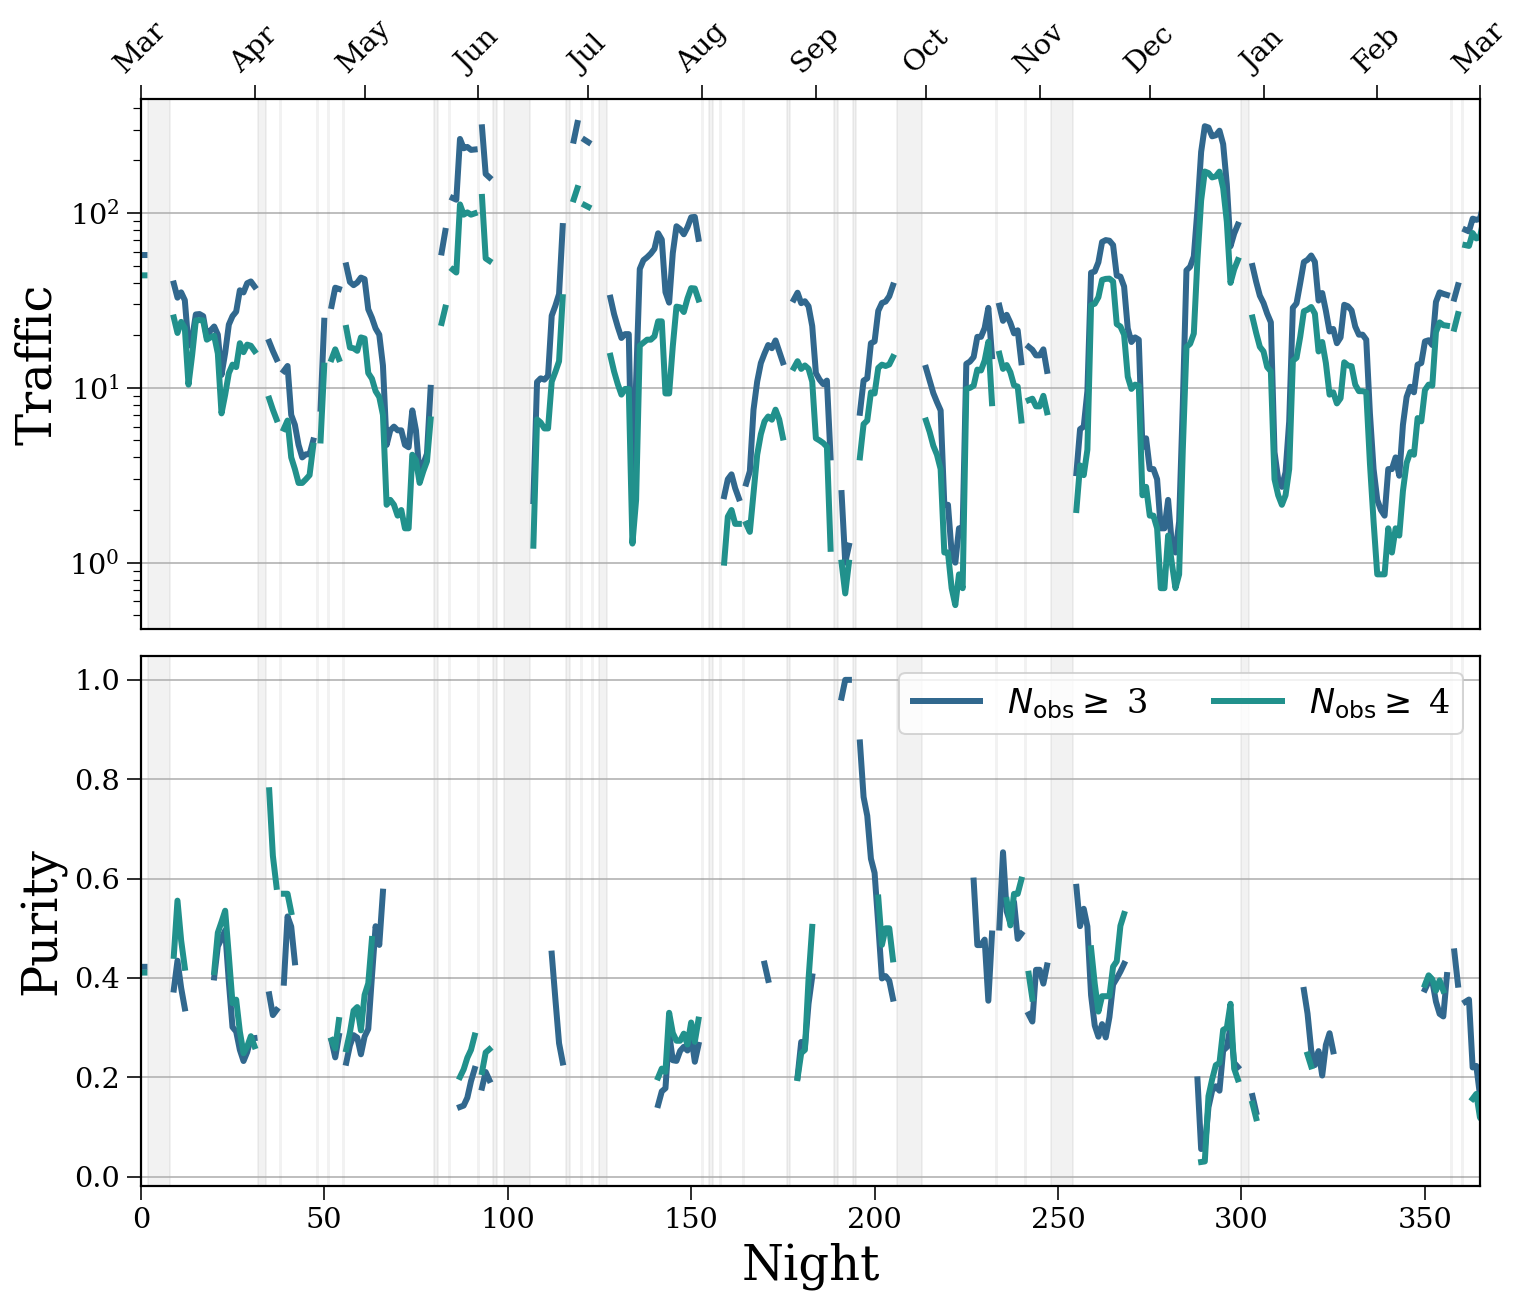

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

n_obs_range = [1, 2]

for i in n_obs_range:#range(len(n_obs_list)):
    axes[0].plot(nights, weekly_mean(total_traffic_unfindable.T[i], bad_weather),
                 color=colours[i], lw=3)
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

for i in n_obs_range:#range(len(n_obs_list)):
    axes[1].plot(nights, weekly_mean(purity_unfindable.T[i], bad_weather),
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    
# axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")

# leg = axes[0].legend(loc="center right", bbox_to_anchor=(1.32, 0))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)
    
leg = axes[1].legend(loc="upper right", ncol=2, fontsize=0.7*fs)
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["March", "April", "May", "June", "July", "August", "September",
          "October", "November", "December", "January", "February", "March"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    i = 0
    while i < len(bad_weather):
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather):
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1

plt.show()

0.02195945945945946
0.23493432256966923
0.0
0.22082404973761485


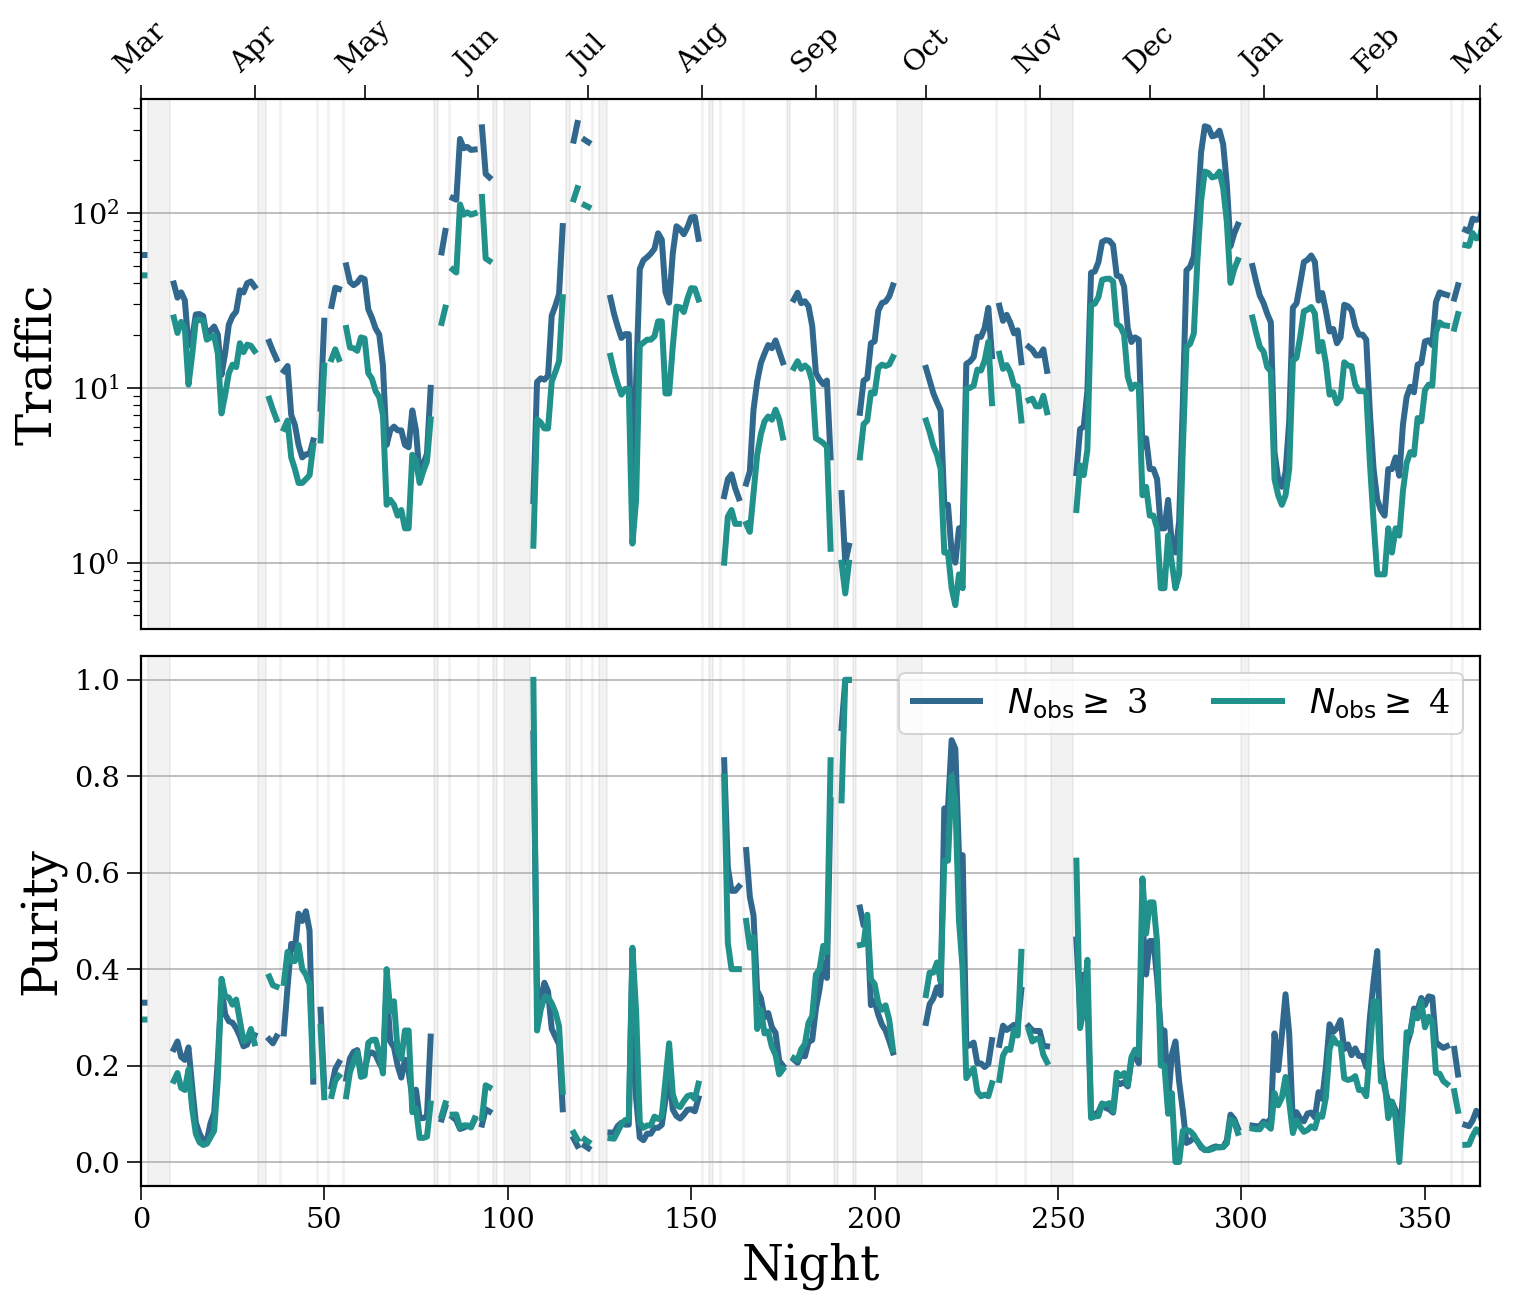

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

n_obs_range = [1, 2]

for i in n_obs_range:#range(len(n_obs_list)):
    axes[0].plot(nights, weekly_mean(total_traffic_unfindable.T[i], bad_weather),
                 color=colours[i], lw=3)
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

for i in n_obs_range:#range(len(n_obs_list)):
    purity = weekly_mean(neo_counts_unfindable.T[i], bad_weather) / weekly_mean(total_traffic_unfindable.T[i], bad_weather)
    axes[1].plot(nights, purity,
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    print(np.min(purity[np.logical_not(np.isnan(purity))]))
    print(np.mean(purity[np.logical_not(np.isnan(purity))]))
    
# axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")

# leg = axes[0].legend(loc="center right", bbox_to_anchor=(1.32, 0))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)
    
leg = axes[1].legend(loc="upper right", ncol=2, fontsize=0.7*fs)
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["March", "April", "May", "June", "July", "August", "September",
          "October", "November", "December", "January", "February", "March"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    i = 0
    while i < len(bad_weather):
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather):
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1

plt.show()

# Which MBAs are getting confused?

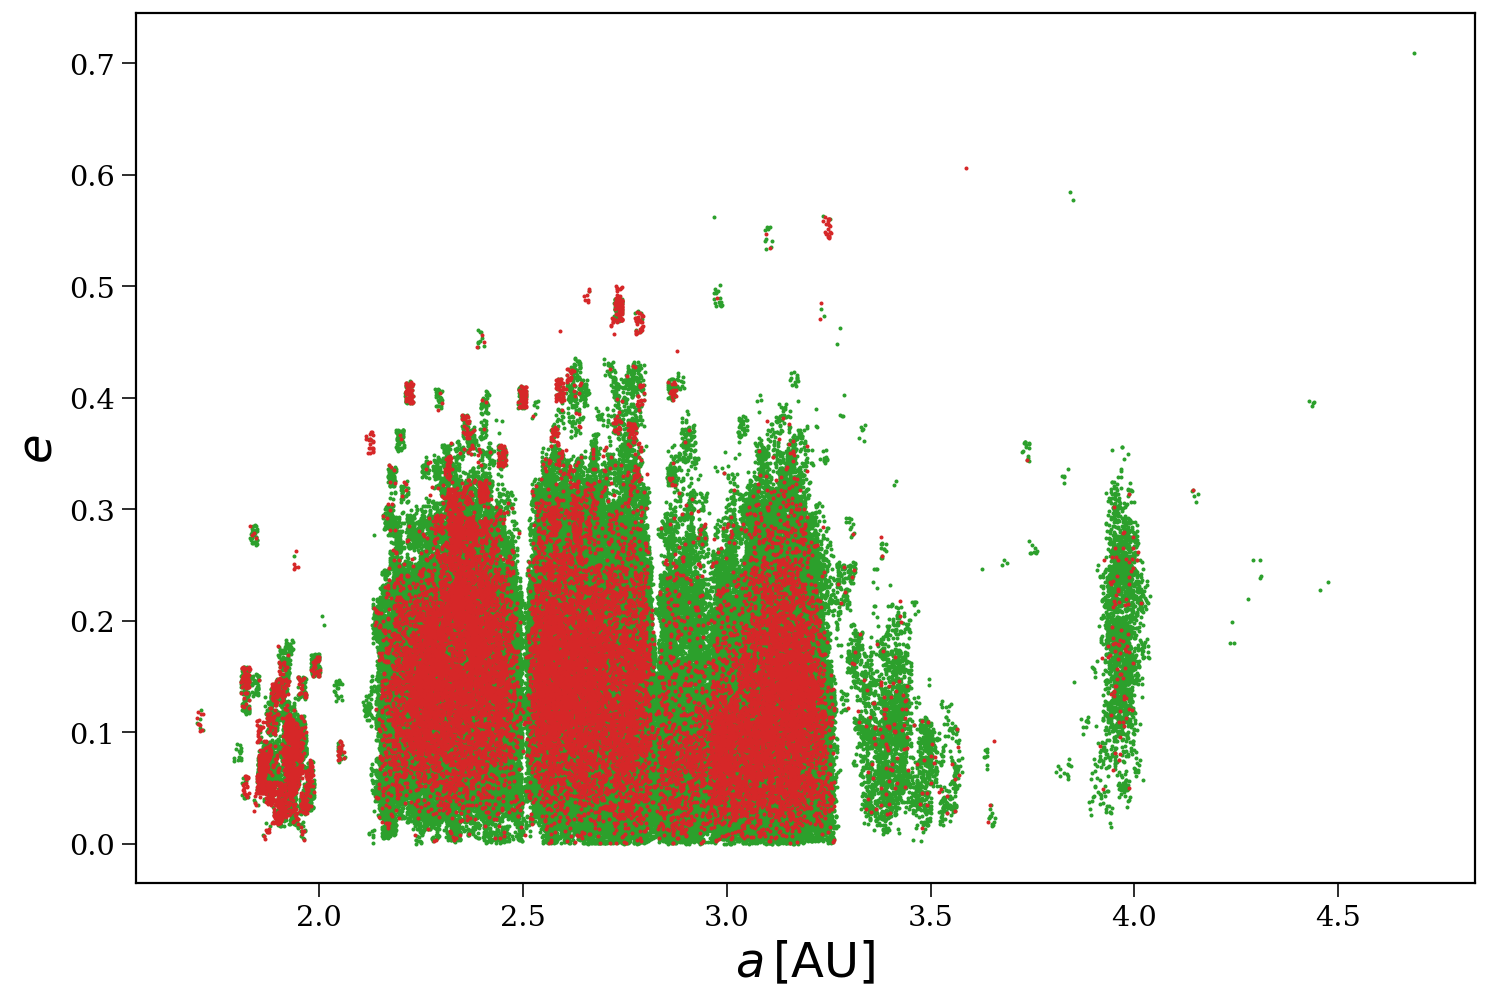

In [45]:
fig, ax = plt.subplots()

obs = pd.read_hdf("mba/" + f"filtered_visit_scores_{0:03d}.h5").sort_values("night")

for crits, colour in [[(0, 65), "tab:green"], [(65, 101), "tab:red"]]:
    ids = obs[np.logical_and.reduce((obs["scores"] >= crits[0],
                                     obs["scores"] < crits[1]))]["ObjID"]
    s3m_obs = s3m[s3m.index.isin(ids)]

    ax.scatter(s3m_obs["q"] / (1 - s3m_obs["e"]), s3m_obs["e"], s=1, color=colour)
    
ax.set_xlabel(r"$a \, [\rm AU]$")
ax.set_ylabel(r"$e$")
    
plt.show()

# Print score statistics

In [376]:
night = 95

In [377]:
S0_scores, S0_labels = helpers.get_neo_scores("neo/", night=night)
S1_scores, S1_labels = helpers.get_neo_scores("mba/", night=night)

if S0_scores is None:
    print(f"No NEO observations on night {night}")
if S1_scores is None:
    print(f"No MBA observations on night {night}")

In [378]:
correct_S0 = S0_labels[S0_scores >= 65]
incorrect_S0 = S0_labels[S0_scores < 65]

In [379]:
correct_S1 = S1_labels[S1_scores < 65]
incorrect_S1 = S1_labels[S1_scores >= 65]

In [380]:
print("{:1.2f}% of NEOs were correctly identified".format(len(correct_S0) / len(S0_scores) * 100))
print("{:1.2f}% of MBAs were correctly identified".format(len(correct_S1) / len(S1_scores) * 100))

82.75% of NEOs were correctly identified
81.93% of MBAs were correctly identified


In [381]:
print("But only {:1.2f}% of objects classified as NEOs are actually NEOs".format(len(correct_S0) / (len(correct_S0) + len(incorrect_S1)) * 100))
print("But only {} of {} objects classified as NEOs are actually NEOs".format(len(correct_S0), (len(correct_S0) + len(incorrect_S1))))

But only 0.95% of objects classified as NEOs are actually NEOs
But only 470 of 49538 objects classified as NEOs are actually NEOs


# Histograms

In [383]:
neo_scores = [
    {
        "scores": S0_scores,
        "label": "NEOs",
        "colour": list(plt.get_cmap("tab10")(1))
    },
    {
        "scores": S1_scores,
        "label": "MBAs",
        "colour": list(plt.get_cmap("tab10")(4))
    },
]

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Night 95'}, xlabel='NEO Score', ylabel='Density'>)

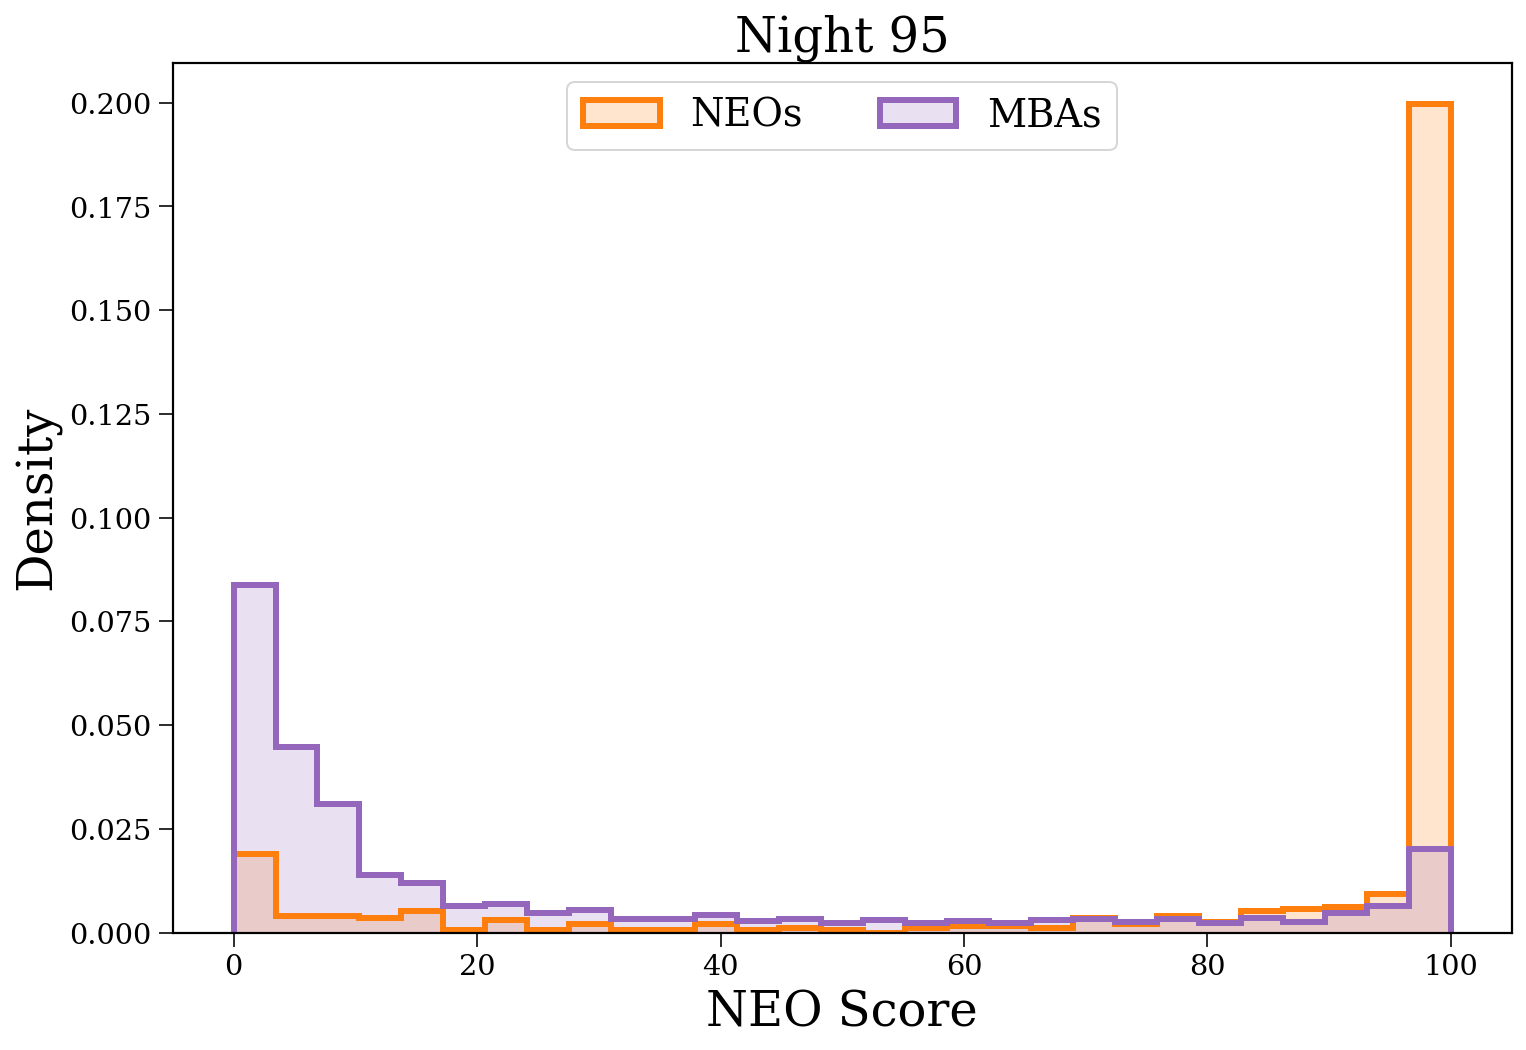

In [384]:
helpers.plot_neo_scores(neo_scores, density=True, night=night)

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Night 95'}, xlabel='NEO Score', ylabel='Number of objects'>)

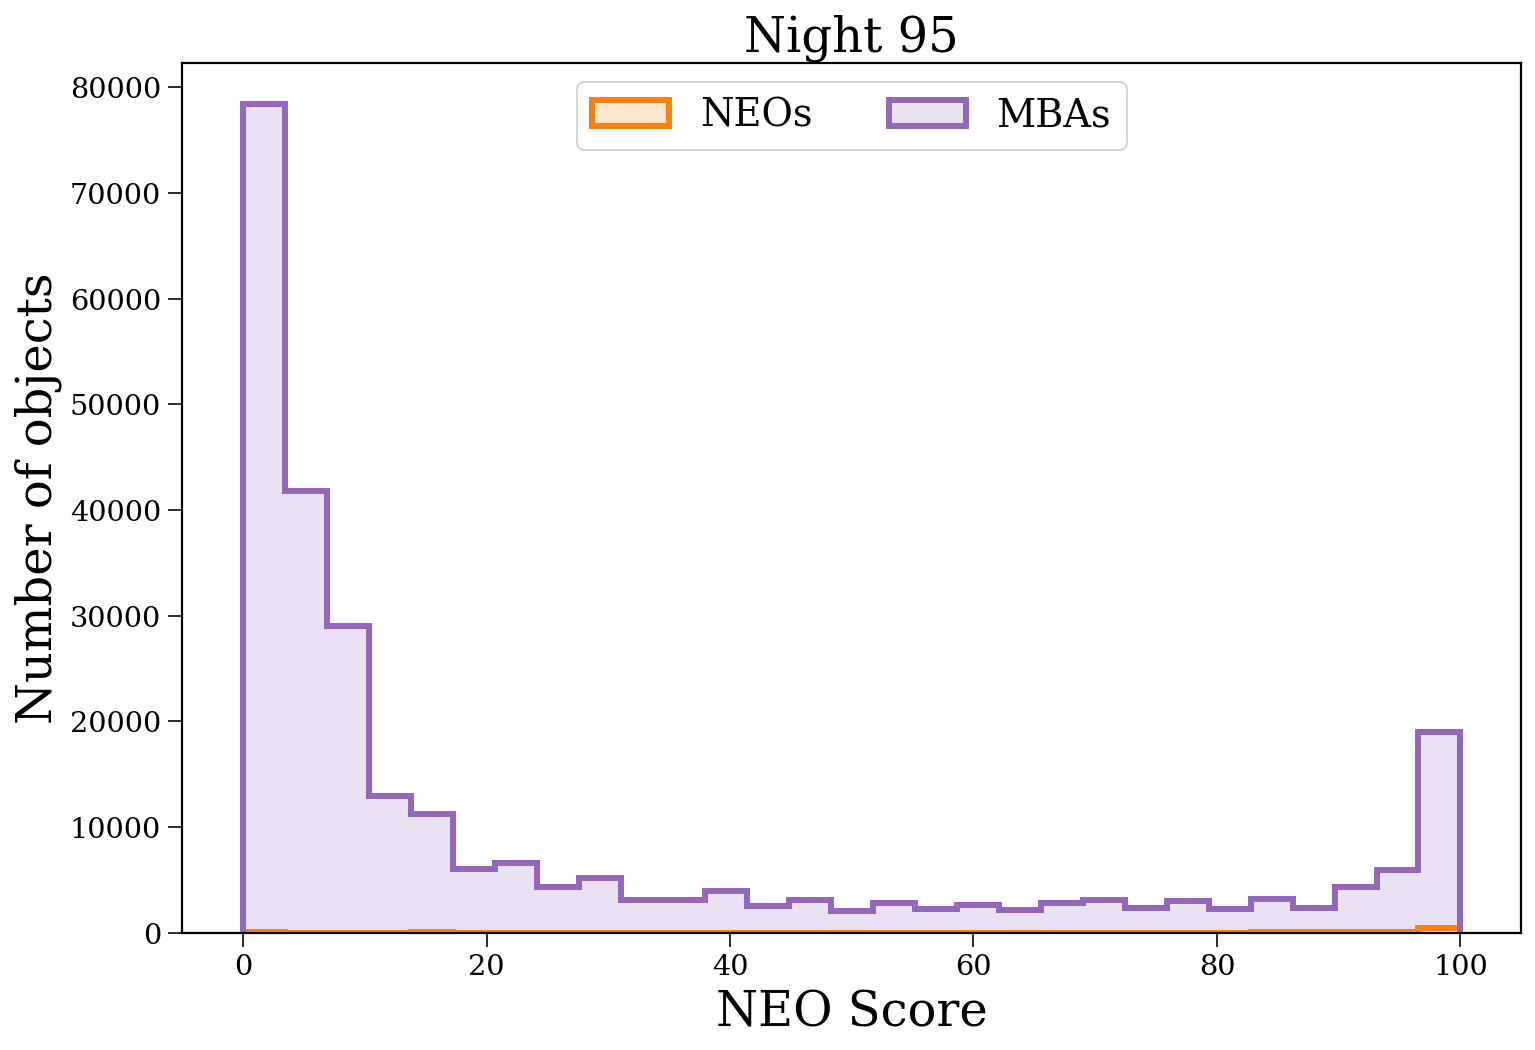

In [385]:
helpers.plot_neo_scores(neo_scores, night=night)

# Sky projections

## Set up ecliptic plane

In [386]:
lon = coord.Angle(np.linspace(-180, 179.9, 1000)*u.degree)
lat = coord.Angle(np.zeros(1000)*u.degree)

ecliptic = coord.SkyCoord(lon=lon, lat=lat, frame='geocentrictrueecliptic').transform_to("icrs")
ecliptic.ra.radian = coord.Angle(ecliptic.ra).wrap_at('180d').radian

## Get RA/Dec

In [398]:
def get_file_table(obj_type="NEO", max_nights=200, night_zero=59638):
    assert obj_type in ["NEO", "MBA"]
    
    # set the path to the observations
    if obj_type == "NEO":
        in_path = "/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/"
    else:
        in_path = [f"/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S1_{i:02d}/" for i in range(14)]

    table = []

    file = 0
    nights_done = 0
    while nights_done < max_nights:
        if isinstance(in_path, str):
            df = pd.read_hdf(in_path + f"visit-{int(file * 1e4):07}.h5")
        else:
            dfs = [pd.read_hdf(in_path[i] + f"visit-{int(file * 1e4):07}.h5") for i in range(len(in_path))]
            df = pd.concat(dfs)
        df["night"] = (df["FieldMJD"] - 0.5).astype(int)
        df["night"] -= night_zero

        table.append(list(sorted(df["night"].unique())))

        nights_done = df["night"].max() - 1

        print(file, nights_done)
        
        file += 1
    
    return table

In [408]:
",".join([str(f2n[i][1]) for i in range(len(f2n))])

'1,20,35,47,62,73,90,113,133,145,160,172,186,203,225,240,261,276,290,309,323,338,351,366'

In [486]:
",".join([str(thing) for i in range(len(f2n)) for thing in f2n[i][2:] ])

'9,10,11,12,13,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30,31,36,37,39,40,41,42,43,44,45,46,49,50,52,53,54,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,74,75,76,77,78,79,82,83,85,86,87,88,89,91,93,94,95,98,107,108,109,110,111,112,114,115,118,119,121,122,124,128,129,130,131,132,134,135,136,137,138,139,140,141,142,143,144,146,147,148,149,150,151,152,154,157,159,161,162,163,165,166,167,168,169,170,171,173,174,175,178,179,180,181,182,183,184,185,187,188,191,192,193,196,197,198,199,200,201,202,204,205,214,215,216,217,218,219,220,221,222,223,224,226,227,228,229,230,231,232,234,235,236,237,238,239,242,243,244,245,246,247,255,256,257,258,259,260,262,263,264,265,266,267,268,269,270,271,272,273,274,275,277,278,279,280,281,282,283,284,285,286,287,288,289,291,292,293,294,295,296,297,298,299,303,304,305,306,307,308,310,311,312,313,314,315,316,317,318,319,320,321,322,324,325,326,327,328,329,330,331,332,333,334,335,336,337,339,340,341,342,343,344,345,346,347,348,349,350,352,353,354,355,356,358

In [128]:
# f2n_NEO = get_file_table(obj_type="NEO")
# f2n_MBA = get_file_table(obj_type="MBA")
np.save("f2n_NEO.npy", f2n_NEO)
np.save("f2n_MBA.npy", f2n_MBA)

/astro/users/tomwagg/.conda/envs/solar_system/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


## Plot it!

In [314]:
sky_positions = [
    {
        "obs": neo_obs,
        "mask": neo_obs["hex_id"].isin(correct_S0),
        "label": "NEOs",
        "s": 0.1,
        "m": "o",
        "z": 10,
    },
    {
        "obs": mba_obs,
        "mask": mba_obs["hex_id"].isin(correct_S1),
        "label": "MBAs",
        "s": 0.05,
        "m": "^",
        "z": 9
    }
]

(-1.5707963267948966, 1.5707963267948966)


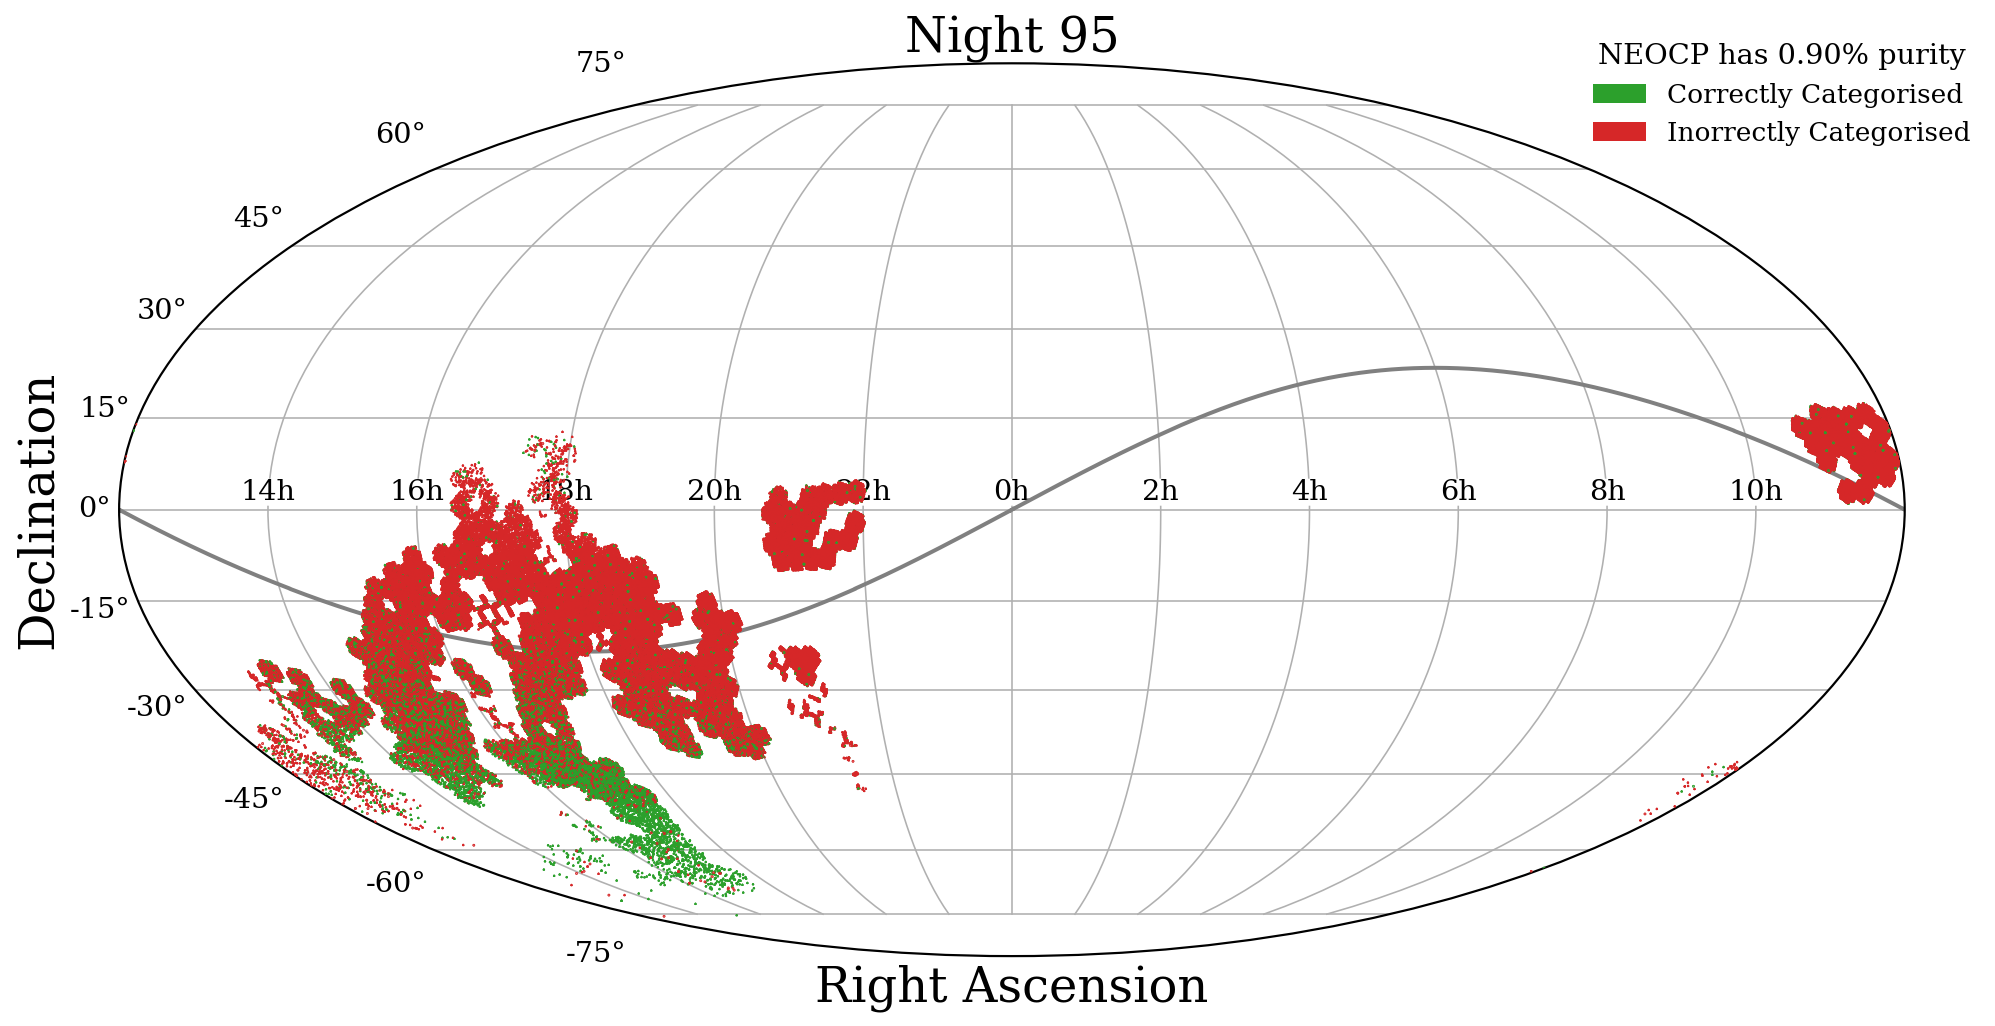

In [354]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection="mollweide")

for sp in sky_positions:
    colours = np.array([plt.get_cmap("tab10")(2) for i in range(len(sp["obs"]["AstRA(deg)"]))])
    colours[sp["mask"]] = plt.get_cmap("tab10")(3)

    ra = coord.Angle(sp["obs"]["AstRA(deg)"].values * u.deg).wrap_at('180d').radian
    dec = (sp["obs"]["AstDec(deg)"].values * u.deg).to(u.rad)
    
    ax.scatter(ra, dec, s=sp["s"], label=sp["label"], marker=sp["m"], c=colours, zorder=sp["z"])
    
ax.plot(ecliptic.ra.radian, ecliptic.dec.radian, color='grey', lw=2)

ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'],
                   bbox=dict(boxstyle="round", fc="white", pad=0.0, ec="none"))
ax.grid(True)

ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")

handles = [
    Patch(facecolor=plt.get_cmap("tab10")(2),
          label="Correctly Categorised", lw=3),
    Patch(facecolor=plt.get_cmap("tab10")(3),
          label="Inorrectly Categorised", lw=3),
]

leg = ax.legend(handles=handles, fontsize=0.55 * fs, loc="upper right", bbox_to_anchor=(1.05, 1.05), 
                edgecolor="white", framealpha=1)

leg.set_title(f"NEOCP has {len(correct_S0) / (len(correct_S0) + len(incorrect_S1)) * 100:1.2f}% purity")
leg.get_title().set_fontsize(fontsize=0.6*fs)

ax.set_title(f"Night {night}", fontsize=fs)

plt.show()